In [1]:
''' Creation: 2021.09.07
    Last update: 2021.09.20
    
    Useful functions for correctly parsing the aging data files
    '''
# Standard library imports
from pathlib import Path

# Setting globals
DEFAULT_DIR = Path.home()   
DATA_BASE_NAME = 'pv.db'
DATA_BASE_TABLE = 'PV_descp'
USED_COLS = ['Voc', 'Isc', 'Rseries', 'Rshunt', 'Pmax', 'Vpm', 'Ipm',
       'Fill Factor',]

PARAM_UNIT_DIC = {'IrrCorr':'W/m2',
            'Pmax':'W',
            'Voc':'V',
            'Isc':'A',
            'Fill Factor':''}


def data_parsing(filepath,parse_all=True):
    
    '''
    The function `data_parsing` reads a csv file organized as follow:
    
                ==========  =================================
                Title:       HET JNHM72 6x12 M2 0200W
                Comment:     
                Op:          Util
                ID:          JINERGY3272023326035_0200W_T0
                Mod Type:    ModuleType1
                Date:        2/15/2021
                ...          ...
                Voltage:     Current:
                -0.740710    1.8377770
                -0.740387    1.8374640
                -0.734611    1.8376460
                ...          ....
                Ref Cell:   Lamp I:
                199.9875    200.0105
                199.9824    200.1674
                ...         ...
                Voltage1:   Current1:
                -0.740710   1.8377770
                -0.740387   1.8374640
                -0.734611   1.8376460
                ...         ....
                Ref Cell1:  Lamp I1:
                ...         ....
                Voltage2:   Current2:
                -0.740710   1.8377770
                -0.740387   1.8374640
                -0.734611   1.8376460
                ...         ....
                Ref Cell2:  Lamp I2:
                0.008593    1.823402
                0.043122    1.823085
                ...         ....
                DarkRsh:    0
                DarkV:       ark I:
                ==========  =================================
    
    The `.csv` file is parsed in a namedtuple `data` where:
       
       - data.IV0, data.IV1, data.IV2 are dataframes containing the `IV` curves as :
       
                ======== ==========
                Voltage	 Current
                ======== ==========
                0.008593  1.823402
                0.043122  1.823085
                0.070891  1.823253
                xxxx      xxxx
                50.0      1.823253
                ======== ==========
       - data.Ref_Cell0, data.Ref_Cell1, data.Ref_Cell2 are dataframes containing
       the irradiance curves as:
       
                ======== ==========
                Ref_Cell  Lamp_I
                ======== ==========
                199.9875  200.0105
                199.9824  200.1674
                xxxxx     xxxxx
                199.9824  200.0074
                ======== ==========
       - data.meta_data is a dict containing the header :
    .. code-block:: python 
    
      data.meta_data = {
      "Title":"HET JNHM72 6x12 M2 0200W",
      "Comment":"",
      "Op":"Util",
      .... :.....,
      }
      
    Args:
        filename (Path): name of the .csv file
    
    Returns:
        data (namedtuple): results of the file parsing (see summary)
    
    '''
    
    # Standard library imports
    from collections import namedtuple
    
    # 3rd party imports
    import numpy as np
    import pandas as pd


    data_struct = namedtuple("PV_module_test", 
                             ["meta_data", 
                              "IV0",
                              "IV1",
                              "IV2",
                              "Ref_Cell0",
                              "Ref_Cell1",
                              "Ref_Cell2"]
                             )
    
    df_data = pd.read_csv(filepath,
                          sep=',',
                          skiprows=0,
                          header=None
                          ) 

    index_data_header = np.where(df_data.iloc[:,0].str.contains('^ Volt|Ref Cell', # Find the indice of the
                                                                case=True,         # headers of th IV and
                                                                regex=True))[0]    # Ref Cell data
    
    index_data_header = np.insert(index_data_header,          # Insersion of index 0 and the index of th
                                  [0,len(index_data_header)], # last numerical value
                                  [0,len(df_data)-3])

    meta_data = df_data.iloc[np.r_[index_data_header[0]:
                                   index_data_header[1]]]
    meta_data = dict(zip(meta_data[0],meta_data[1]))
    meta_data = {key.split(':')[0]:val for key,val  in meta_data.items()} 
    
    if not parse_all:
        data = data_struct(meta_data=meta_data,
                       IV0=None,
                       IV1=None,
                       IV2=None,
                       Ref_Cell0=None,
                       Ref_Cell1=None,
                       Ref_Cell2=None,
                      )
        return data
        

    list_df = []
    for i in range(1,len(index_data_header)-1):
        dg = df_data.iloc[np.r_[index_data_header[i]+1:
                                index_data_header[i+1]]].astype(float)

        dg = dg.loc[dg[0] > 0]
        dg.index = list(range(len(dg)))
        
        if 'Voltage' in  df_data.iloc[index_data_header[i]][0]:
            dg.columns = ['Voltage','Current']
        else:
            dg.columns = ['Ref_Cell','Lamp_I']
            
        list_df.append(dg) 
        
    data = data_struct(meta_data=meta_data,
                       IV0=list_df[0],
                       IV1=list_df[2],
                       IV2=list_df[4],
                       Ref_Cell0=list_df[1],
                       Ref_Cell1=list_df[3],
                       Ref_Cell2=list_df[0],
                      )
    return data


def select_files():
    
    '''The function `select_files` interactively selects *.txt or *.txt files from
    a directory.
    
    Args:
       DEFAULT_DIR (Path, global): root directory used for the file selection.
       
    Returns:
       filenames (list of str): list of selected files
    '''
    
    # Standard library imports
    import tkinter as tk
    from tkinter import ttk
    from tkinter import filedialog as fd


    root = tk.Tk()
    root.title('File Dialog')
    root.resizable(False, False)
    root.geometry('300x150')
    global filenames, filetypes
    filetypes = (
            ('csv files', '*.csv'),
            ('text files', '*.txt'), 
            )

    def select_files_():
        global filenames,filetypes
        
        filenames = fd.askopenfilenames(
            title='Select files',
            initialdir=DEFAULT_DIR,
            filetypes=filetypes)

    open_button = ttk.Button(
        root,
        text='Select Files',
        command=select_files_)
    open_button.pack(expand=True)
    
    if os.name == 'nt':
        tk.Button(root,
                  text="EXIT",
                  command=root.destroy).pack(expand=True)

    root.mainloop()
    
    return filenames

def parse_filename(file):
    
    '''
    Let the string "file" structured as follow:
      '~/XXXXXXX<ddddddddddddd>_<dddd>W_T<d>.csv'
    where <> is a placeholder, d a digit, X a capital letter and ~ the relative or absolute path of the file
    
    parse_filename parses "file" in three chunks: JINERGY<ddddddddddddd>, <dddd>, T<d> and stores them in
    the nametuple FileInfo.
    
    Args:
       file (str): filename to parse
    
    Returns:
        data (namedtuple): results of the file parsing (see summary)
        
    Examples:
    let file = 'C:/Users/franc/PVcharacterization_files/JINERGY3272023326035_0200W_T2.csv'
    we obtain:
        FileInfo.power = 200
        FileInfo.time = "T2"
        FileInfo.time = "JINERGY3272023326035"
    
    '''
    #Standard library imports
    from collections import namedtuple
    import re
    
    FileNameInfo = namedtuple('FileNameInfo','power time name file')
    re_power = re.compile(r'(?<=\_)\d{4}(?=W\_)') 
    re_time = re.compile(r'(?<=\_)T\d{1}(?=\.)') 
    re_name = re.compile(r'[A-Z]*\d{1,15}(?=\_)')

    
    FileInfo = FileNameInfo(power=int(re.findall(re_power,file)[0]),
                            time=re.findall(re_time,file)[0],
                            name=re.findall(re_name,file)[0],
                            file=file)
    return FileInfo

def df2sqlite(dataframe, file=None, tbl_name = "import"):
    
    '''The function df2sqlite converts a dataframe into a squlite database.
    
    Args:
       dataframe (panda.DataFrame): the dataframe to convert in a data base
       file (Path): full pathname of the database
       tbl_name (str): name of the table
    '''
    
    import sqlite3
    
    if file is None:
        conn = sqlite3.connect(":memory:")
    else:
        conn = sqlite3.connect(file)
        
    cur = conn.cursor() 
    wildcards = ','.join(['?'] * len(dataframe.columns)) 
    data = [tuple(x) for x in dataframe.values]
    cur.execute(f"DROP TABLE IF EXISTS {tbl_name}" )
    col_str = '"' + '","'.join(dataframe.columns) + '"'
    cur.execute(f"CREATE TABLE {tbl_name} ({col_str})")
    cur.executemany(f"insert into {tbl_name} values ({wildcards})",data)
    conn.commit()
    cur.close()
    conn.close()
    
def sieve_files(pow_select,time_select,name_select,database_path ):
    
    '''The sieve_files select 
    '''
    # Standard library imports
    import sqlite3
    from string import Template
    
    conv2str = lambda list_ : str(tuple(list_)).replace(",)", ")")

    conn = sqlite3.connect(database_path)
    cur = conn.cursor()

    querry_d = Template('''SELECT file
                        FROM PV_descp 
                        WHERE name  IN $name_select
                        AND power IN $pow_select
                        AND time IN $time_select
                        ORDER BY name ASC
                        LIMIT 50''')

    cur.execute(querry_d.substitute({'name_select':conv2str(name_select),
                                     'pow_select':conv2str(pow_select),
                                     'time_select':conv2str(time_select)}))

    querry = [x[0] for x in cur.fetchall()]
    cur.close()
    conn.close()
    return querry

def plot_diff_param(params,df_meta):
    
    # Standard library imports
    from itertools import combinations
    
    #3rd party import
    import matplotlib.pyplot as plt
    import numpy as np
    
    

    pow_list = sorted(list(set(df_meta['power'].tolist())))
    pow_add_nbr = 2
    pow_median = (min(pow_list) + max(pow_list)) / 2
    pow_add = (max(pow_list) - min(pow_list)) / 2
    pow_min, pow_max = min(pow_list) - pow_add_nbr*pow_add, max(pow_list) + pow_add_nbr*pow_add

    nbr_time = len(set(df_meta['time'].tolist()))
    assert nbr_time>1,'not enough time measurements. Should be greeter than 1'
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(len(params),int(nbr_time*(nbr_time-1)/2), hspace=0, wspace=0)
    ax = gs.subplots(sharex='col', sharey='row')
    
    color = ['k','b','g']
    list_exp = list(set(df_meta['name']))
    
    for k,exp in enumerate(list_exp):
        df_exp = df_meta.query('name == @exp')

        # split df_exp into a dic keyed by time (T0,T1,...). The values are dataframe df_exp
        # with column time=T0,T1,...
        dic_time = {}
        set_times = set(df_exp['time'].tolist())
        for time in set_times:
            dic_time[time] = df_exp.loc[df_exp['time']==time ,:]


        list_t = sorted(list(set(df_exp['time'].tolist())))

        for j,param in enumerate(params):
            dic_time_cp = {}

            for time in combinations(list_t, 2):
                val = np.array(dic_time[time[1]][param].astype(float).tolist())
                ref = np.array(dic_time[time[0]][param].astype(float).tolist())
                delta = 100*(val - ref)/ref
                dic_time_cp[time[1]+'-'+time[0]] = dic_time[time[1]].copy()
                dic_time_cp[time[1]+'-'+time[0]]['Delta_'+param] = delta

            list_items = sorted(dic_time_cp.keys())
            if len(list_items) ==1:
                key = list(dic_time_cp.keys())[0]
                ax[j].scatter(dic_time_cp[key]['power'], dic_time_cp[key]['Delta_'+param],c=color[k])
                ax[j].axhline(y=0, color='red', linestyle='--')
                if j==0: ax[j].set_title(key)
                ax[j].set_xlabel('Power ($W/{m^2}$)')
                ax[j].set_ylabel('$\Delta$ '+param+' (%)')
                ax[j].tick_params(axis='x', rotation=90)
                ax[j].set_xlim([pow_min, pow_max])
                ax[j].set_ylim([-3.2,1.6])
                if param=='Rseries': ax[j].set_ylim([-30,30])
                for axis in ['top','bottom','left','right']:
                    ax[j].spines[axis].set_linewidth(2)
            else:
                for i,key in enumerate(list_items):
                    ax[j,i].scatter(dic_time_cp[key]['power'], dic_time_cp[key]['Delta_'+param],c=color[k])
                    ax[j,i].axhline(y=0, color='red', linestyle='--')
                    if j==0: ax[j,i].set_title(key)
                    ax[j,i].set_xlabel('Power ($W/{m^2}$)')
                    if i==0: ax[j,i].set_ylabel('$\Delta$ '+param+' (%)')
                    ax[j,i].tick_params(axis='x', rotation=90)
                    ax[j,i].set_xticks(pow_list, minor=False)
                    ax[j,i].set_xticklabels(pow_list, fontsize=12)
                    ax[j,i].set_xlim([pow_min, pow_max])
                    ax[j,i].set_ylim([-3.2,1.6])
                    if param=='Rseries': ax[j,i].set_ylim([-30,30])
                    for axis in ['top','bottom','left','right']:
                        ax[j,i].spines[axis].set_linewidth(2)
                        
                    
    fig.suptitle(chr(9679)+' '+list_exp[0], fontsize=15)
    fig.subplots_adjust(top=0.95)
    
def read_electolum_file(file):

    """
    Args:
        file (Path): absolute path of the binary file
        
    Returns:
        imgWidth (integer): number of rows
        
        imgHeight (integer): number of columns
        
        confocal_img (NxM nparray of floats): confocal image z in µm
        
        image ndarray) : electroluminescence image

    """
   
    
    # Standard library import
    import struct
    from collections import namedtuple

    # 3rd party imports
    import numpy as np

    data_struct = namedtuple("PV_electrolum", 
                             ["imgWidth", 
                              "imgHeight",
                              "numPatterns",
                              "image",
                              ]
                             )
    data = open(file, "rb").read()

    # Header parsing
    fmt = "2i"
    imgWidth,imgHeight = struct.unpack(fmt, data[: struct.calcsize(fmt)])
    pos = struct.calcsize(fmt)+4
    fmt = "i"
    numPatterns = struct.unpack(fmt, data[pos: pos+struct.calcsize(fmt)])[0]

    # Images parsing
    list_images = []
    for numPattern in range(numPatterns):
        fmt = str(imgWidth*imgHeight) + "H"
        pos = 1024 * 4 + numPattern * struct.calcsize(fmt)
        
        y = struct.unpack(fmt, data[pos : pos + struct.calcsize(fmt)])
        list_images.append( np.array(y).reshape((imgHeight,imgWidth)))
    
    image = np.concatenate( tuple(list_images), axis=0 )
    
    electrolum = data_struct(imgWidth,
                            imgHeight,
                            numPatterns,
                            image)

    return electrolum
        

In [2]:
''' Creation: 2021.09.12
    Last update: 2021.09.20
    
    User specific paths definition
    
    '''

# Standard library imports
import os
from pathlib import Path

# 3rd party import
import pandas as pd

# List of available bow data files
datafiles_list = select_files()
#datafiles_list = list(datafiles_list)
#datafiles_list.sort()

list_files_descp = [parse_filename(file) for file in datafiles_list]
    
df_files_descp  = pd.DataFrame(list_files_descp)

database_path = Path(os.path.dirname(datafiles_list[0])) / Path(DATA_BASE_NAME)

df2sqlite(df_files_descp, file=database_path, tbl_name=DATA_BASE_TABLE)

print('Datafiles list built')

Datafiles list built


In [3]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    
    '''
# Standard library imports
import os

pow_select = [200,400,600,800,1000,2000]
name_select = ["JINERGY3272023326035",]
time_select = ["T0", "T1", "T2"]

querries = sieve_files(pow_select,time_select,name_select,database_path)


df_files_descp_copy = df_files_descp

df_files_descp_copy.index = [os.path.basename(x).split('.')[0] for x in df_files_descp_copy['file'].tolist()]
df_files_descp_copy = df_files_descp_copy.loc[:,['power','time','name'] ]

res = [data_parsing(querry,parse_all=False).meta_data for querry in querries]
df_meta = pd.DataFrame.from_dict(res)
df_meta.index = df_meta['ID']
df_meta = df_meta.loc[:,USED_COLS]

df_meta = pd.merge(df_meta,df_files_descp_copy,left_index=True, right_index=True)
df_meta

,Voc,Isc,Rseries,Rshunt,Pmax,Vpm,Ipm,Fill Factor,power,time,name
ID,,,,,,,,,,,
JINERGY3272023326035_0200W_T0,50.5082,1.827,1.95841,1593.92,72.2867,42.5857,1.69744,0.78335,200,T0,JINERGY3272023326035
JINERGY3272023326035_0200W_T1,50.6780,1.82484,1.87985,1874.07,72.5313,42.7868,1.69517,0.78429,200,T1,JINERGY3272023326035
JINERGY3272023326035_0200W_T2,50.3452,1.79790,2.09313,875.055,71.105,42.5312,1.67182,0.78555,200,T2,JINERGY3272023326035
JINERGY3272023326035_0400W_T0,51.8321,3.61464,1.05142,703.805,148.082,44.0490,3.36175,0.79038,400,T0,JINERGY3272023326035
JINERGY3272023326035_0400W_T1,51.9387,3.61127,0.96906,795.822,148.774,44.2281,3.36379,0.79319,400,T1,JINERGY3272023326035
JINERGY3272023326035_0400W_T2,51.6677,3.55743,1.01058,827.496,145.590,43.7553,3.32737,0.79209,400,T2,JINERGY3272023326035
JINERGY3272023326035_0600W_T0,52.4938,5.39540,0.68749,632.893,223.513,44.4636,5.02687,0.78917,600,T0,JINERGY3272023326035
JINERGY3272023326035_0600W_T1,52.6060,5.39036,0.72844,714.475,224.548,44.6874,5.02485,0.79187,600,T1,JINERGY3272023326035
JINERGY3272023326035_0600W_T2,52.3567,5.30642,0.80821,913.975,219.481,44.0355,4.98419,0.78999,600,T2,JINERGY3272023326035


WARNING parameter bidon will be ignored
WARNING parameter trarmiz will be ignored


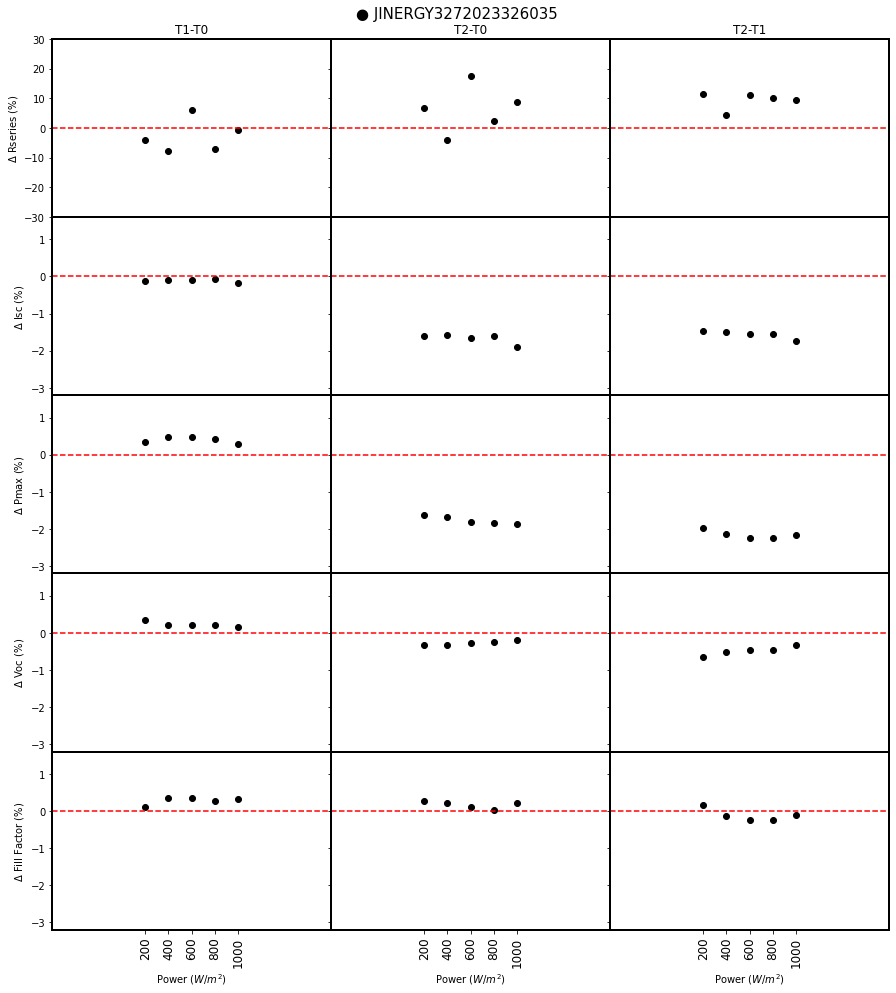

In [4]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    Plotting of parameters evolution.
    
    '''
params = ['Pmax','Voc','Isc','Fill Factor','Rseries','bidon','trarmiz']

unkown_params = set(params).difference(set(USED_COLS))
for unknow_param in unkown_params:
    print(f'WARNING parameter {unknow_param} will be ignored')
    
params = set(USED_COLS).intersection(set(params)) 

plot_diff_param(params,df_meta)

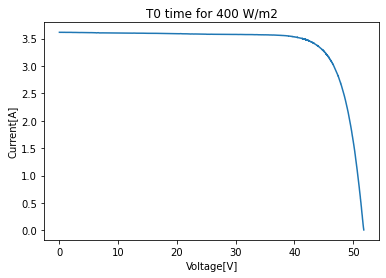

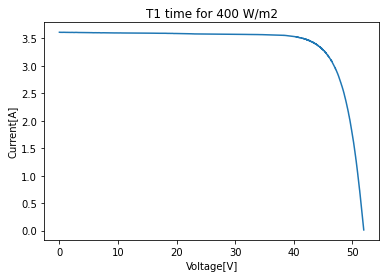

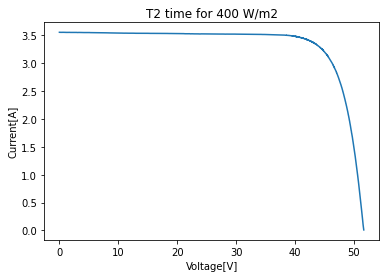

In [5]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    Plotting of I/V curves.
    
    '''



import matplotlib.pyplot as plt

pow_select = [400]
name_select = ["JINERGY3272023326035",]
time_select = ["T0","T1","T2"]



querries = sieve_files(pow_select,time_select,name_select,database_path)

for i, res in enumerate([data_parsing(querry).IV0 for querry in querries]):
    plt.plot(res['Voltage'],res['Current'])
    plt.xlabel(res.columns[0] +'[V]')
    plt.ylabel(res.columns[1] +'[A]')
    plt.title(f'{time_select[i]} time for {str(pow_select[0])} {PARAM_UNIT_DIC["IrrCorr"]}')
    
    plt.show()

    

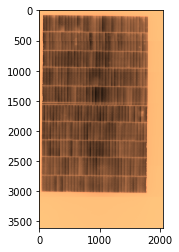

In [6]:
# Standard library import
from pathlib import Path

# 3rd party imports
import matplotlib.pyplot as plt

file = DEFAULT_DIR / Path("PVcharacterization_files") / Path("SERAPHIM-EM-0640_Isc_ap500hXDH.dat")

electrolum = read_electolum_file(file)


plt.imshow(electrolum.image,
           cmap='copper_r',
           interpolation=None)
plt.show()
